In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore, ttest_ind, mannwhitneyu
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
from sklearn.exceptions import DataConversionWarning,ConvergenceWarning

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [3]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from scipy.spatial.distance import pdist

In [4]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from numpy import where

In [5]:
from sklearn.utils import resample

In [6]:
train = pd.read_csv(r'C:\Users\anura\Desktop\Capstone Project\Fraud Detection\Training_Test\UNSW_NB15_training-set.csv')
train.head(2)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0


In [7]:
dfc = train.copy()

In [8]:
test = pd.read_csv(r'C:\Users\anura\Desktop\Capstone Project\Fraud Detection\Training_Test\UNSW_NB15_testing-set.csv')
test.head(2)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0


In [9]:
train.shape, test.shape

((175341, 45), (82332, 45))

In [10]:
train.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)
dfc.drop('id', axis = 1, inplace = True)

In [11]:
df_cat = train.select_dtypes(include = 'object')
df_num = train.select_dtypes(exclude = 'object')

In [12]:
for i in df_cat.columns:
    print(i, df_cat[i].nunique())

proto 133
service 13
state 9
attack_cat 10


In [13]:
for i in ['proto', 'service', 'state']:
    dic = dict(df_cat.groupby(i)['attack_cat'].count()/df_cat.shape[0])
    df_cat[i] = df_cat[i].map(dic)
df_cat

<ipython-input-13-7532b321132e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[i] = df_cat[i].map(dic)


,proto,service,state,attack_cat
0,0.455946,0.537056,0.443849,Normal
1,0.455946,0.537056,0.443849,Normal
2,0.455946,0.537056,0.443849,Normal
3,0.455946,0.019550,0.443849,Normal
4,0.455946,0.537056,0.443849,Normal
...,...,...,...,...
175336,0.360914,0.269726,0.469229,Generic
175337,0.455946,0.537056,0.443849,Shellcode
175338,0.360914,0.269726,0.469229,Generic
175339,0.360914,0.269726,0.469229,Generic


In [14]:
df_cat['attack_cat'].value_counts()

Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64

In [15]:
atk_lab = {'Normal' : 0, 'Generic' : 1, 'Exploits' : 2, 'Fuzzers' : 3, 'DoS' : 4, 'Reconnaissance' : 5,
          'Analysis' : 6, 'Backdoor' : 7, 'Shellcode' : 8, 'Worms' : 9}
df_cat['attack_label'] = df_cat['attack_cat'].map(atk_lab)

<ipython-input-15-c1c422358285>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat['attack_label'] = df_cat['attack_cat'].map(atk_lab)


In [16]:
for i in ['proto', 'service', 'state']:
    dic = dict(test.groupby(i)['attack_cat'].count()/test.shape[0])
    test[i] = test[i].map(dic)
test

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,0.357309,0.572718,0.414942,2,0,496,0,90909.090200,254,...,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,0.357309,0.572718,0.414942,2,0,1762,0,125000.000300,254,...,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,0.357309,0.572718,0.414942,2,0,1068,0,200000.005100,254,...,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,0.357309,0.572718,0.414942,2,0,900,0,166666.660800,254,...,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,0.357309,0.572718,0.414942,2,0,2126,0,100000.002500,254,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,0.357309,0.572718,0.414942,2,0,104,0,200000.005100,254,...,1,2,0,0,0,2,1,0,Normal,0
82328,1.106101,0.523430,0.572718,0.477809,20,8,18062,354,24.410067,254,...,1,1,0,0,0,3,2,0,Normal,0
82329,0.000000,0.011988,0.572718,0.414942,1,0,46,0,0.000000,0,...,1,1,0,0,0,1,1,1,Normal,0
82330,0.000000,0.011988,0.572718,0.414942,1,0,46,0,0.000000,0,...,1,1,0,0,0,1,1,1,Normal,0


In [17]:
test['attack_label'] = test['attack_cat'].map(atk_lab)
test.head(2)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label,attack_label
0,0.000011,0.357309,0.572718,0.414942,2,0,496,0,90909.0902,254,...,2,0,0,0,1,2,0,Normal,0,0
1,0.000008,0.357309,0.572718,0.414942,2,0,1762,0,125000.0003,254,...,2,0,0,0,1,2,0,Normal,0,0


In [18]:
df = pd.concat([df_num, df_cat], axis = 1)
df.head(2)

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto,service,state,attack_cat,attack_label
0,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,...,0,1,1,0,0,0.455946,0.537056,0.443849,Normal,0
1,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,...,0,1,6,0,0,0.455946,0.537056,0.443849,Normal,0


## ------------------------ Decision Tree --------------------------------------------

In [36]:
X = df.drop(['attack_cat', 'attack_label'], axis = 1)
Y = df['attack_cat']

In [27]:
X.shape, Y.shape

((175341, 43), (175341,))

In [28]:
Xtest = test.drop('attack_cat', axis = 1)
Ytest = test['attack_cat']

In [29]:
Xtest.shape, Ytest.shape

((82332, 43), (82332,))

In [24]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X, Y)

DecisionTreeClassifier(random_state=0)

In [25]:
dt.score(X,Y)

0.9091142402518521

In [30]:
dt.score(Xtest, Ytest)

0.04246222610892484

## ------------------------------------- Random Forest ---------------------------------------------------

In [16]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 0)

In [17]:
df_RF = pd.concat([df_num, df_cat], axis = 1)
df_RF.head(2)

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto,service,state,attack_cat,attack_label
0,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,...,0,1,1,0,0,0.455946,0.537056,0.443849,Normal,0
1,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,...,0,1,6,0,0,0.455946,0.537056,0.443849,Normal,0


In [18]:
X_RF = df_RF.drop(['attack_cat', 'attack_label'], axis = 1)
Y_RF = df_RF['attack_label']

In [19]:
Xtest_RF = test.drop(['attack_cat', 'attack_label'], axis = 1)
Ytest_RF = test['attack_label']

In [47]:
RF = RandomForestClassifier()
param = {'n_estimators' : [100, 150, 200, 250], 'criterion' : ['entropy', 'gini'], 'max_depth' : range(1,11), 'n_jobs' : [-1]}
GS = GridSearchCV(RF, param, cv = kf, n_jobs = -1, scoring = 'f1_weighted')
GS.fit(X_RF, Y_RF)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 11),
                         'n_estimators': [100, 150, 200, 250], 'n_jobs': [-1]},
             scoring='f1_weighted')

In [48]:
GS.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 150, 'n_jobs': -1}

In [49]:
RF = RandomForestClassifier()
param = {'n_estimators' : [100, 150, 200, 250], 'criterion' : ['entropy', 'gini'], 'max_depth' : range(10,20), 'n_jobs' : [-1]}
GS = GridSearchCV(RF, param, cv = kf, n_jobs = -1, scoring = 'f1_weighted')
GS.fit(X_RF, Y_RF)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(10, 20),
                         'n_estimators': [100, 150, 200, 250], 'n_jobs': [-1]},
             scoring='f1_weighted')

In [50]:
GS.best_params_

{'criterion': 'entropy', 'max_depth': 19, 'n_estimators': 100, 'n_jobs': -1}

In [51]:
RF = RandomForestClassifier()
param = {'n_estimators' : [80, 100, 150, 200], 'criterion' : ['entropy', 'gini'], 'min_samples_leaf' : range(2,6), 'n_jobs' : [-1]}
GS = GridSearchCV(RF, param, cv = kf, n_jobs = -1, scoring = 'f1_weighted')
GS.fit(X_RF, Y_RF)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'min_samples_leaf': range(2, 6),
                         'n_estimators': [80, 100, 150, 200], 'n_jobs': [-1]},
             scoring='f1_weighted')

In [52]:
GS.best_params_

{'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 200, 'n_jobs': -1}

In [19]:
RF = RandomForestClassifier()
param = {'n_estimators' : [200, 220, 250, 280, 300], 'criterion' : ['entropy', 'gini'], 'min_samples_leaf' : range(2,4), 'n_jobs' : [-1]}
GS = GridSearchCV(RF, param, cv = kf, n_jobs = -1, scoring = 'f1_weighted')
GS.fit(X_RF, Y_RF)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'min_samples_leaf': range(2, 4),
                         'n_estimators': [200, 220, 250, 280, 300],
                         'n_jobs': [-1]},
             scoring='f1_weighted')

In [20]:
GS.best_params_

{'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 300, 'n_jobs': -1}

In [22]:
RF = RandomForestClassifier()
param = {'n_estimators' : [300, 320, 350, 380, 400], 'criterion' : ['entropy', 'gini'], 'min_samples_leaf' : [2], 'n_jobs' : [-1]}
GS = GridSearchCV(RF, param, cv = kf, n_jobs = -1, scoring = 'f1_weighted')
GS.fit(X_RF, Y_RF)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'min_samples_leaf': [2],
                         'n_estimators': [300, 320, 350, 380, 400],
                         'n_jobs': [-1]},
             scoring='f1_weighted')

In [23]:
GS.best_params_

{'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 320, 'n_jobs': -1}

In [20]:
RF = RandomForestClassifier(n_estimators = 320, criterion = 'gini', min_samples_leaf = 2, n_jobs = -1)
RF.fit(X_RF, Y_RF)

RandomForestClassifier(min_samples_leaf=2, n_estimators=320, n_jobs=-1)

In [21]:
RF.score(X_RF, Y_RF)

0.9035137246850423

In [22]:
RF.score(Xtest_RF, Ytest_RF)

0.12924500801632416

In [25]:
pt = PowerTransformer()
xtn = pt.fit_transform(X_RF)
xtt = pt.transform(Xtest_RF)

In [26]:
RF = RandomForestClassifier()
param = {'n_estimators' : [200, 250, 280, 300, 320, 350], 'criterion' : ['entropy', 'gini'], 'min_samples_leaf' : [2], 'n_jobs' : [-1]}
GS = GridSearchCV(RF, param, cv = kf, n_jobs = -1, scoring = 'f1_weighted')
GS.fit(xtn, Y_RF)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'min_samples_leaf': [2],
                         'n_estimators': [200, 250, 280, 300, 320, 350],
                         'n_jobs': [-1]},
             scoring='f1_weighted')

In [27]:
GS.best_params_

{'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 320, 'n_jobs': -1}

In [28]:
RF = RandomForestClassifier(n_estimators = 320, criterion = 'gini', min_samples_leaf = 2, n_jobs = -1)
RF.fit(xtn, Y_RF)

RandomForestClassifier(min_samples_leaf=2, n_estimators=320, n_jobs=-1)

In [29]:
RF.score(xtn, Y_RF)

0.9035935691024917

In [30]:
RF.score(xtt, Ytest_RF)

0.14287275907302144

## ---------------------------------------------------------------------------------------------

In [19]:
atk_lab

{'Normal': 0,
 'Generic': 1,
 'Exploits': 2,
 'Fuzzers': 3,
 'DoS': 4,
 'Reconnaissance': 5,
 'Analysis': 6,
 'Backdoor': 7,
 'Shellcode': 8,
 'Worms': 9}

In [20]:
df['attack_cat'].value_counts()

Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64

In [21]:
df['attack_label'] = df['attack_label'].replace({9 : 4, 6 : 5, 8 : 7})
test['attack_label'] = test['attack_label'].replace({9 : 4, 6 : 5, 8 : 7})

In [22]:
df['attack_label'] = df['attack_label'].replace({7:6})
test['attack_label'] = test['attack_label'].replace({7:6})

In [23]:
df['attack_label'].value_counts()

0    56000
1    40000
2    33393
3    18184
5    12491
4    12394
6     2879
Name: attack_label, dtype: int64

In [24]:
Xtrain = df.drop(['attack_cat', 'attack_label'], axis = 1)
Ytrain = df['attack_label']
Xtest = test.drop(['attack_cat', 'attack_label'], axis = 1)
Ytest = test['attack_label']

In [25]:
Xtr_cols = Xtrain.columns
Xtest = Xtest.loc[:, Xtr_cols]

In [26]:
Xtrain.shape, Xtest.shape

((175341, 43), (82332, 43))

In [24]:
xgb = XGBClassifier(random_state = 0)
xgb.fit(Xtrain, Ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
xgb.score(Xtrain, Ytrain)

0.8913887795780793

In [26]:
xgb.score(Xtest, Ytest)

0.8870062673079726

In [27]:
ypred_train = xgb.predict(Xtrain)
ypred_test = xgb.predict(Xtest)

In [28]:
pd.Series(ypred_train).value_counts()

0    56000
2    50585
1    39549
3    16808
5     9248
6     1660
4     1491
dtype: int64

In [29]:
pd.Series(ypred_test).value_counts()

0    37000
1    18367
2    15364
3     4919
5     3608
6     2269
4      805
dtype: int64

In [30]:
confusion_matrix(Ytrain, ypred_train)

array([[56000,     0,     0,     0,     0,     0,     0],
       [    0, 39515,   442,    18,    12,     2,    11],
       [    0,    18, 32704,   180,    83,   307,   101],
       [    0,     8,  1607, 16490,     5,    17,    57],
       [    0,     8, 10821,    64,  1376,    50,    75],
       [    0,     0,  3594,     4,    11,  8839,    43],
       [    0,     0,  1417,    52,     4,    33,  1373]], dtype=int64)

In [31]:
confusion_matrix(Ytest, ypred_test)

array([[37000,     0,     0,     0,     0,     0,     0],
       [    0, 18322,   464,    28,    26,     4,    27],
       [    0,    21,  9647,   244,   174,   400,   646],
       [    0,     9,  1108,  4370,    98,    86,   391],
       [    0,    14,  2751,   113,   415,   212,   628],
       [    0,     1,   998,    74,    50,  2874,   176],
       [    0,     0,   396,    90,    42,    32,   401]], dtype=int64)

In [32]:
# Accuracy
print('Train Accuracy\t:', accuracy_score(Ytrain, ypred_train))
print('Test Accuracy \t:', accuracy_score(Ytest, ypred_test))

Train Accuracy	: 0.8913887795780793
Test Accuracy 	: 0.8870062673079726


In [33]:
# Precision
print('Train Precision\t:', precision_score(Ytrain, ypred_train, average = 'weighted'))
print('Test Precision \t:', precision_score(Ytest, ypred_test, average = 'weighted'))

Train Precision	: 0.9190808685935375
Test Precision 	: 0.8966685163233752


In [34]:
# Recall
print('Train Recall\t:', recall_score(Ytrain, ypred_train, average = 'weighted'))
print('Test Recall \t:', recall_score(Ytest, ypred_test, average = 'weighted'))

Train Recall	: 0.8913887795780793
Test Recall 	: 0.8870062673079726


In [35]:
# F1 Score
print('Train f1 score\t:', f1_score(Ytrain, ypred_train, average = 'weighted'))
print('Test f1 score \t:', f1_score(Ytest, ypred_test, average = 'weighted'))

Train f1 score	: 0.8739662083916955
Test f1 score 	: 0.8807875830346257


In [128]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 0)

In [131]:
RF_ve = []
for i in [30, 50, 70, 90, 100, 120, 150]:
    print('Estimators:', i)
    RF = RandomForestClassifier(n_estimators = i, criterion = 'gini', min_samples_leaf = 2,
                                random_state = 0, n_jobs = -1)
    score = cross_val_score(RF, Xtrain, Ytrain, cv = kf, scoring = 'f1_weighted')
    RF_ve.append(np.std(score, ddof = 1))

Estimators: 30
Estimators: 50
Estimators: 70
Estimators: 90
Estimators: 100
Estimators: 120
Estimators: 150


In [132]:
RF_ve

[0.0016698294379546208,
 0.0017922672069872736,
 0.0015381311603907234,
 0.0015258795935522854,
 0.0015146774448038032,
 0.0014256054062656794,
 0.0015782141129033372]

In [ ]:
np.min(RF_ve), np.argmin(RF_ve)

In [135]:
RF_ve = []
for i in [30, 50, 70, 90, 100, 120, 150]:
    print('Estimators:', i)
    RF = RandomForestClassifier(n_estimators = i, criterion = 'entropy', min_samples_leaf = 2,
                                random_state = 0, n_jobs = -1)
    score = cross_val_score(RF, Xtrain, Ytrain, cv = kf, scoring = 'f1_weighted')
    RF_ve.append(np.std(score, ddof = 1))

Estimators: 30
Estimators: 50
Estimators: 70
Estimators: 90
Estimators: 100
Estimators: 120
Estimators: 150


In [136]:
RF_ve

[0.001541637704575045,
 0.0018272541475145277,
 0.0017674244712371757,
 0.0019505149670482496,
 0.0018696519396394604,
 0.00173091691647347,
 0.0016975117155327507]

In [138]:
np.min(RF_ve), np.argmin(RF_ve)

(0.001541637704575045, 0)

In [37]:
RF = RandomForestClassifier(n_estimators = 120, criterion = 'gini', min_samples_leaf = 2,
                           random_state = 0, n_jobs = -1)
ada = AdaBoostClassifier(random_state = 0)
ada.fit(Xtrain, Ytrain)

AdaBoostClassifier(random_state=0)

In [38]:
ada.score(Xtrain, Ytrain)

0.8286538801535294

In [39]:
ada.score(Xtest, Ytest)

0.7887698586211922

In [40]:
ypred_train = ada.predict(Xtrain)
ypred_test = ada.predict(Xtest)

In [41]:
pd.Series(ypred_train).value_counts()

0    56000
2    49324
1    39138
3    18994
5    11394
4      480
6       11
dtype: int64

In [42]:
pd.Series(ypred_test).value_counts()

0    37000
2    17381
1    13436
3    10102
5     4268
4      133
6       12
dtype: int64

In [43]:
confusion_matrix(Ytrain, ypred_train)

array([[56000,     0,     0,     0,     0,     0,     0],
       [    0, 37498,   746,  1721,    11,    24,     0],
       [    0,   436, 29559,  1554,   202,  1637,     5],
       [    0,   833,  2335, 14328,    28,   660,     0],
       [    0,   228, 11235,   344,   175,   411,     1],
       [    0,    75,  3765,   877,    42,  7732,     0],
       [    0,    68,  1684,   170,    22,   930,     5]], dtype=int64)

In [44]:
confusion_matrix(Ytest, ypred_test)

array([[37000,     0,     0,     0,     0,     0,     0],
       [    0, 12205,   595,  6046,     5,    19,     1],
       [    0,   273,  9722,   496,    66,   570,     5],
       [    0,   517,  2005,  3140,     3,   397,     0],
       [    0,   216,  3573,   139,    48,   155,     2],
       [    0,   113,   998,   228,    10,  2823,     1],
       [    0,   112,   488,    53,     1,   304,     3]], dtype=int64)

In [45]:
# Accuracy
print('Train Accuracy\t:', accuracy_score(Ytrain, ypred_train))
print('Test Accuracy \t:', accuracy_score(Ytest, ypred_test))

Train Accuracy	: 0.8286538801535294
Test Accuracy 	: 0.7887698586211922


In [46]:
# Precision
print('Train Precision\t:', precision_score(Ytrain, ypred_train, average = 'weighted'))
print('Test Precision \t:', precision_score(Ytest, ypred_test, average = 'weighted'))

Train Precision	: 0.811883156595748
Test Precision 	: 0.8106807023558884


In [47]:
# Recall
print('Train Recall\t:', recall_score(Ytrain, ypred_train, average = 'weighted'))
print('Test Recall \t:', recall_score(Ytest, ypred_test, average = 'weighted'))

Train Recall	: 0.8286538801535294
Test Recall 	: 0.7887698586211922


In [48]:
# F1 Score
print('Train f1 score\t:', f1_score(Ytrain, ypred_train, average = 'weighted'))
print('Test f1 score \t:', f1_score(Ytest, ypred_test, average = 'weighted'))

Train f1 score	: 0.7997122704229718
Test f1 score 	: 0.7784931219435302


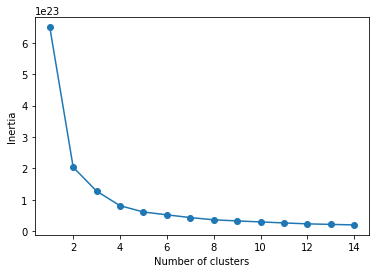

In [65]:
wcss = []
for i in range(1,15):
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(Xtrain)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,15), wcss, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [66]:
for i in range(1,12):
    print('Moving from', i, 'clusters to', i+1, 'clusters\t:', wcss[i] - wcss[i-1])

Moving from 1 clusters to 2 clusters	: -4.459625905597795e+23
Moving from 2 clusters to 3 clusters	: -7.61553933131612e+22
Moving from 3 clusters to 4 clusters	: -4.642513251450458e+22
Moving from 4 clusters to 5 clusters	: -2.0066997166230563e+22
Moving from 5 clusters to 6 clusters	: -9.004353147282248e+21
Moving from 6 clusters to 7 clusters	: -8.721162537074373e+21
Moving from 7 clusters to 8 clusters	: -7.125502127040507e+21
Moving from 8 clusters to 9 clusters	: -3.549009426629754e+21
Moving from 9 clusters to 10 clusters	: -3.219202136845509e+21
Moving from 10 clusters to 11 clusters	: -3.2053884106723903e+21
Moving from 11 clusters to 12 clusters	: -2.96057196442968e+21


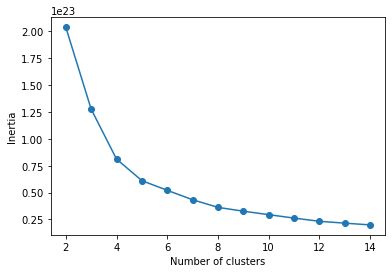

In [67]:
wcss = []
for i in range(2,15):
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(Xtrain)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(2,15), wcss, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [68]:
for i in range(1,12):
    print('Moving from', i+1, 'clusters to', i+2, 'clusters\t:', wcss[i] - wcss[i-1])

Moving from 2 clusters to 3 clusters	: -7.615539331316114e+22
Moving from 3 clusters to 4 clusters	: -4.64251325145046e+22
Moving from 4 clusters to 5 clusters	: -2.0066997166230555e+22
Moving from 5 clusters to 6 clusters	: -9.00435314728224e+21
Moving from 6 clusters to 7 clusters	: -8.721162537074365e+21
Moving from 7 clusters to 8 clusters	: -7.125502127040507e+21
Moving from 8 clusters to 9 clusters	: -3.5490094266297667e+21
Moving from 9 clusters to 10 clusters	: -3.2192021368454964e+21
Moving from 10 clusters to 11 clusters	: -3.205388410672403e+21
Moving from 11 clusters to 12 clusters	: -2.96057196442968e+21
Moving from 12 clusters to 13 clusters	: -1.7360565480587012e+21


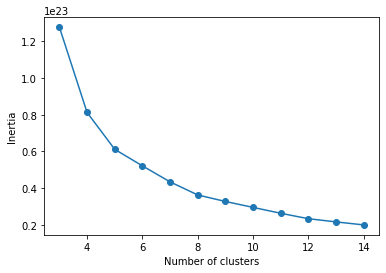

In [69]:
plt.plot(range(3,15), wcss[1:], marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [73]:
Z = linkage(Xtrain, 'ward')
dendrogram(Z, leaf_rotation = 90, truncate_mode = 'level', p = 5)
plt.show()

MemoryError: Unable to allocate 115. GiB for an array with shape (15372145470,) and data type float64

In [74]:
Z = linkage(Xtest, 'ward')
dendrogram(Z, leaf_rotation = 90, truncate_mode = 'level', p = 5)
plt.show()

MemoryError: Unable to allocate 25.3 GiB for an array with shape (3389237946,) and data type float64

In [75]:
Xtest.shape

(82332, 43)

## ------------------------------------------------------------------------------------------------------

In [30]:
# Backward Elimination - Logistic Regression
LR = LogisticRegression(max_iter = 300, random_state = 0, n_jobs = -1)
back_mod = sfs(estimator = LR, k_features = 'best', forward = False, scoring = 'r2', n_jobs = -1)
back_feat = back_mod.fit(Xtrain, Ytrain)
back_feat_names = list(back_feat.k_feature_names_)

C:\Users\anura\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [34]:
print('Number of features:', len(back_feat_names))
print(back_feat_names)
print(back_feat.k_score_)

Number of features: 4
['sbytes', 'dload', 'sinpkt', 'stcpb']
0.15917146499835924


## -----------------------------------------------------------------------------------------

In [26]:
Ytrain.value_counts()

0    56000
1    40000
2    33393
3    18184
5    12491
4    12394
6     2879
Name: attack_label, dtype: int64

In [27]:
over = SMOTE(sampling_strategy = {3 : 20000, 4 : 13900, 5 : 14000, 6 : 6000})
X, y = over.fit_resample(Xtrain, Ytrain)
y.value_counts()

0    56000
1    40000
2    33393
3    20000
5    14000
4    13900
6     6000
Name: attack_label, dtype: int64

In [28]:
xgb = XGBClassifier(random_state = 0)
xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
xgb.score(X,y), xgb.score(Xtest, Ytest)

(0.881555760449117, 0.8713622892678424)

In [30]:
ypred_train = xgb.predict(X)
ypred_test = xgb.predict(Xtest)

In [31]:
print(classification_report(y, ypred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56000
           1       1.00      0.99      0.99     40000
           2       0.65      0.91      0.76     33393
           3       0.98      0.91      0.94     20000
           4       0.51      0.28      0.36     13900
           5       0.95      0.71      0.81     14000
           6       0.85      0.61      0.71      6000

    accuracy                           0.88    183293
   macro avg       0.85      0.77      0.80    183293
weighted avg       0.89      0.88      0.88    183293



In [32]:
print(classification_report(Ytest, ypred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37000
           1       1.00      0.97      0.98     18871
           2       0.73      0.73      0.73     11132
           3       0.96      0.69      0.80      6062
           4       0.44      0.14      0.21      4133
           5       0.91      0.68      0.78      4173
           6       0.10      0.74      0.18       961

    accuracy                           0.87     82332
   macro avg       0.73      0.71      0.67     82332
weighted avg       0.92      0.87      0.88     82332



In [33]:
under = RandomUnderSampler(sampling_strategy = {0 : 51000, 1 : 37000, 2 : 31000})
X, y = under.fit_resample(X, y)
y.value_counts()

0    51000
1    37000
2    31000
3    20000
5    14000
4    13900
6     6000
Name: attack_label, dtype: int64

In [34]:
xgb = XGBClassifier(random_state = 0)
xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
xgb.score(X,y), xgb.score(Xtest, Ytest)

(0.8780046269519953, 0.8713501433221591)

In [36]:
ypred_train = xgb.predict(X)
ypred_test = xgb.predict(Xtest)

In [37]:
print(classification_report(y, ypred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51000
           1       1.00      0.99      0.99     37000
           2       0.66      0.87      0.75     31000
           3       0.98      0.91      0.94     20000
           4       0.48      0.39      0.43     13900
           5       0.96      0.71      0.82     14000
           6       0.85      0.61      0.71      6000

    accuracy                           0.88    172900
   macro avg       0.85      0.78      0.81    172900
weighted avg       0.89      0.88      0.88    172900



In [38]:
print(classification_report(Ytest, ypred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37000
           1       1.00      0.97      0.98     18871
           2       0.78      0.68      0.73     11132
           3       0.95      0.70      0.81      6062
           4       0.43      0.27      0.33      4133
           5       0.88      0.68      0.77      4173
           6       0.10      0.76      0.18       961

    accuracy                           0.87     82332
   macro avg       0.74      0.72      0.69     82332
weighted avg       0.92      0.87      0.89     82332



In [39]:
xgb = XGBClassifier(random_state = 0)
xgb.fit(X,y)

KeyboardInterrupt: 

## -------------------------------------------------------------------------------

In [27]:
Ytrain.value_counts()

0    56000
1    40000
2    33393
3    18184
5    12491
4    12394
6     2879
Name: attack_label, dtype: int64

In [28]:
Xtrain.columns

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label', 'proto',
       'service', 'state'],
      dtype='object')

In [29]:
over = SMOTE(sampling_strategy = {3 : 20000, 4 : 13900, 5 : 14000, 6 : 6000})
X, y = over.fit_resample(Xtrain, Ytrain)
y.value_counts()

0    56000
1    40000
2    33393
3    20000
5    14000
4    13900
6     6000
Name: attack_label, dtype: int64

In [30]:
under = RandomUnderSampler(sampling_strategy = {0 : 50000, 1 : 36000, 2 : 30000})
X, y = under.fit_resample(X, y)
y.value_counts()

0    50000
1    36000
2    30000
3    20000
5    14000
4    13900
6     6000
Name: attack_label, dtype: int64

In [31]:
resample(y, n_samples = 60000).value_counts()

0    17755
1    12868
2    10409
3     7064
4     4900
5     4860
6     2144
Name: attack_label, dtype: int64

In [32]:
df_smpl = pd.concat([X,y], axis = 1)

In [33]:
df_smpl = resample(df_smpl, n_samples = 50000).reset_index(drop = True)
df_smpl

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto,service,state,attack_label
0,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000e+00,...,0,0,17,31,0,1,0.360914,0.269726,0.469229,1
1,0.000010,2,0,200,0,100000.002500,254,0,8.000000e+07,0.000000e+00,...,0,0,4,4,0,1,0.006559,0.537056,0.469229,2
2,0.000004,2,0,114,0,250000.000600,254,0,1.140000e+08,0.000000e+00,...,0,0,16,16,0,1,0.360914,0.269726,0.469229,1
3,0.031383,54,42,37808,3380,3027.116561,31,29,9.459389e+06,8.412198e+05,...,0,0,11,2,0,0,0.455946,0.028847,0.443849,0
4,0.140161,48,50,2958,33044,692.061308,31,29,1.653527e+05,1.848389e+06,...,0,0,5,9,0,0,0.455946,0.537056,0.443849,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2.014740,36,132,1654,152418,82.889108,62,252,6.388914e+03,6.006294e+05,...,0,0,1,1,0,1,0.455946,0.006302,0.443849,2
49996,0.785462,10,7,1751,339,26.988247,254,252,1.944125e+04,3.640838e+03,...,0,0,4,1,0,1,0.455946,0.537056,0.443849,6
49997,8.061390,74,338,3282,434489,50.983764,62,252,3.213342e+03,4.299050e+05,...,0,0,3,1,0,1,0.455946,0.006302,0.443849,2
49998,1.459901,10,8,848,354,11.644625,254,252,4.186585e+03,1.698745e+03,...,0,1,2,1,0,1,0.455946,0.106786,0.443849,2


In [34]:
X = df_smpl.drop('attack_label', axis = 1)
y = df_smpl['attack_label']

In [40]:
def modl(modl_nm, X_tr, y_tr, X_ts, y_ts):
    modl_nm.fit(X_tr, y_tr)
    print('Train model')
    ypred_train = modl_nm.predict(X_tr)
    ypred_test = modl_nm.predict(X_ts)
    print(classification_report(y_tr, ypred_train))
    print('_'*70)
    print('Test model')
    print(classification_report(y_ts, ypred_test))
    print('_'*70)
    display(pd.DataFrame({'imp' : modl_nm.feature_importances_,
                          'feature' : X_tr.columns}).sort_values(by = 'imp').head())

In [65]:
xgb = XGBClassifier(random_state = 0, nthread = 8)

In [64]:
Xd = X.drop('label', axis = 1)
Xdt = Xtest.drop('label', axis = 1)

In [66]:
modl(xgb, Xd, y, Xdt, Ytest)

Train model
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     14657
           1       1.00      0.99      1.00     10395
           2       0.68      0.91      0.78      9081
           3       0.90      0.87      0.89      5807
           4       0.58      0.46      0.52      4121
           5       0.98      0.74      0.84      4185
           6       0.91      0.62      0.74      1754

    accuracy                           0.88     50000
   macro avg       0.86      0.79      0.82     50000
weighted avg       0.89      0.88      0.88     50000

______________________________________________________________________
Test model
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     37000
           1       1.00      0.97      0.98     18871
           2       0.70      0.69      0.70     11132
           3       0.30      0.56      0.39      6062
           4       0.34      0.22     

,imp,feature
34,0.000000,ct_ftp_cmd
19,0.000000,dwin
33,0.000682,is_ftp_login
29,0.001084,ct_dst_ltm
36,0.001205,ct_src_ltm
18,0.001223,dtcpb
17,0.001305,stcpb
12,0.001361,sinpkt
22,0.001396,ackdat
0,0.001524,dur


In [68]:
inp = Xd.drop(['ct_ftp_cmd', 'dwin'], axis = 1)
inpt = Xdt.drop(['ct_ftp_cmd', 'dwin'], axis = 1)

In [69]:
xgb = XGBClassifier(random_state = 0, nthread = 8)
modl(xgb, inp, y, inpt, Ytest)

Train model
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     14657
           1       1.00      0.99      1.00     10395
           2       0.68      0.91      0.78      9081
           3       0.90      0.87      0.89      5807
           4       0.58      0.46      0.52      4121
           5       0.98      0.74      0.84      4185
           6       0.91      0.62      0.74      1754

    accuracy                           0.88     50000
   macro avg       0.86      0.79      0.82     50000
weighted avg       0.89      0.88      0.88     50000

______________________________________________________________________
Test model
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     37000
           1       1.00      0.97      0.98     18871
           2       0.70      0.69      0.70     11132
           3       0.30      0.56      0.39      6062
           4       0.34      0.22     

,imp,feature
32,0.000682,is_ftp_login
28,0.001084,ct_dst_ltm
34,0.001205,ct_src_ltm
18,0.001223,dtcpb
17,0.001305,stcpb
12,0.001361,sinpkt
21,0.001396,ackdat
0,0.001524,dur
13,0.001524,dinpkt
39,0.001723,state


In [70]:
inp = inp.drop(['is_ftp_login', 'ct_dst_ltm', 'ct_src_ltm'], axis = 1)
inpt = inpt.drop(['is_ftp_login', 'ct_dst_ltm', 'ct_src_ltm'], axis = 1)

In [71]:
xgb = XGBClassifier(random_state = 0, nthread = 8)
modl(xgb, inp, y, inpt, Ytest)

Train model
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     14657
           1       1.00      0.99      1.00     10395
           2       0.67      0.91      0.77      9081
           3       0.90      0.87      0.88      5807
           4       0.58      0.42      0.49      4121
           5       0.97      0.74      0.84      4185
           6       0.90      0.60      0.72      1754

    accuracy                           0.87     50000
   macro avg       0.86      0.79      0.81     50000
weighted avg       0.88      0.87      0.87     50000

______________________________________________________________________
Test model
              precision    recall  f1-score   support

           0       0.97      0.75      0.84     37000
           1       1.00      0.97      0.98     18871
           2       0.68      0.70      0.69     11132
           3       0.30      0.58      0.40      6062
           4       0.35      0.23     

,imp,feature
18,0.001186,dtcpb
12,0.001277,sinpkt
17,0.001354,stcpb
21,0.001395,ackdat
0,0.001488,dur
13,0.001501,dinpkt
36,0.001608,state
28,0.001750,ct_src_dport_ltm
15,0.001849,djit
9,0.002083,dload


In [72]:
inp = inp.drop(['dtcpb', 'sinpkt', 'stcpb'], axis = 1)
inpt = inpt.drop(['dtcpb', 'sinpkt', 'stcpb'], axis = 1)

In [73]:
xgb = XGBClassifier(random_state = 0, nthread = 8)
modl(xgb, inp, y, inpt, Ytest)

Train model
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     14657
           1       1.00      0.99      1.00     10395
           2       0.67      0.91      0.77      9081
           3       0.89      0.86      0.87      5807
           4       0.59      0.42      0.49      4121
           5       0.97      0.73      0.84      4185
           6       0.91      0.60      0.72      1754

    accuracy                           0.87     50000
   macro avg       0.86      0.78      0.81     50000
weighted avg       0.88      0.87      0.87     50000

______________________________________________________________________
Test model
              precision    recall  f1-score   support

           0       0.97      0.75      0.84     37000
           1       1.00      0.97      0.98     18871
           2       0.69      0.69      0.69     11132
           3       0.30      0.58      0.40      6062
           4       0.34      0.26     

,imp,feature
18,0.001397,ackdat
0,0.001531,dur
12,0.001694,dinpkt
14,0.001786,djit
25,0.001787,ct_src_dport_ltm
33,0.001964,state
13,0.002281,sjit
9,0.002288,dload
21,0.002313,trans_depth
5,0.002396,rate


In [74]:
inp = inp.drop(['ackdat', 'dur', 'dinpkt'], axis = 1)
inpt = inpt.drop(['ackdat', 'dur', 'dinpkt'], axis = 1)

In [75]:
xgb = XGBClassifier(random_state = 0, nthread = 8)
modl(xgb, inp, y, inpt, Ytest)

Train model
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     14657
           1       1.00      0.99      1.00     10395
           2       0.66      0.92      0.77      9081
           3       0.89      0.86      0.87      5807
           4       0.58      0.40      0.47      4121
           5       0.97      0.74      0.84      4185
           6       0.91      0.59      0.72      1754

    accuracy                           0.87     50000
   macro avg       0.86      0.78      0.81     50000
weighted avg       0.88      0.87      0.87     50000

______________________________________________________________________
Test model
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     37000
           1       1.00      0.97      0.98     18871
           2       0.69      0.70      0.70     11132
           3       0.30      0.56      0.39      6062
           4       0.37      0.23     

,imp,feature
22,0.001593,ct_src_dport_ltm
4,0.001750,rate
30,0.001843,state
12,0.001865,djit
11,0.001971,sjit
8,0.002073,dload
14,0.002193,tcprtt
7,0.002291,sload
18,0.002519,trans_depth
0,0.002606,spkts


In [76]:
inp = inp.drop(['ct_src_dport_ltm', 'rate', 'state', 'djit', 'sjit',
               'dload', 'tcprtt', 'sload'], axis = 1)
inpt = inpt.drop(['ct_src_dport_ltm', 'rate', 'state', 'djit', 'sjit',
                 'dload', 'tcprtt', 'sload'], axis = 1)

In [77]:
xgb = XGBClassifier(random_state = 0, nthread = 8)
modl(xgb, inp, y, inpt, Ytest)

Train model
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     14657
           1       1.00      0.99      1.00     10395
           2       0.65      0.90      0.76      9081
           3       0.86      0.84      0.85      5807
           4       0.55      0.38      0.45      4121
           5       0.95      0.71      0.81      4185
           6       0.88      0.58      0.70      1754

    accuracy                           0.86     50000
   macro avg       0.84      0.76      0.79     50000
weighted avg       0.87      0.86      0.85     50000

______________________________________________________________________
Test model
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     37000
           1       0.99      0.97      0.98     18871
           2       0.69      0.71      0.70     11132
           3       0.30      0.56      0.39      6062
           4       0.35      0.20     

,imp,feature
0,0.002648,spkts
12,0.002770,trans_depth
13,0.003333,response_body_len
14,0.004094,ct_srv_src
15,0.005342,ct_state_ttl
9,0.005681,synack
7,0.005917,dloss
1,0.006040,dpkts
18,0.006762,ct_flw_http_mthd
3,0.009532,dbytes


In [78]:
inp.shape

(50000, 23)

In [39]:
X.shape

(50000, 43)

In [37]:
kf = KFold(shuffle = True, n_splits = 3, random_state = 0)

In [ ]:
for i in range(43, 20, -1):
    print('Features :', i)
    xgb = XGBClassifier(random_state = 0)
    back_mod = sfs(estimator = xgb, k_features = i, forward = 'False',
                   cv = kf, scoring = 'f1_weighted', n_jobs = -1)
    back_mod.fit(X,y)
    feat_back = list(back_mod.k_feature_names_)
    modl(xgb, X[feat_back], y, Xtest[feat_back], Ytest)
    print('#'*70)

Features : 43



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

Train model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14657
           1       1.00      0.98      0.99     10395
           2       0.51      0.93      0.66      9081
           3       0.79      0.70      0.74      5807
           4       0.69      0.05      0.09      4121
           5       0.97      0.56      0.71      4185
           6       0.63      0.27      0.38      1754

    accuracy                           0.81     50000
   macro avg       0.80      0.64      0.65     50000
weighted avg       0.85      0.81      0.78     50000

______________________________________________________________________
Test model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37000
           1       1.00      0.96      0.98     18871
           2       0.53      0.88      0.66     11132
           3       0.67      0.57      0.62      6062
           4       0.36      0.03     

In [38]:
xgb = XGBClassifier(random_state = 0, nthread = 8)
back_mod = sfs(estimator = xgb, k_features = 42, forward = 'False',
               cv = kf, scoring = 'f1_weighted', n_jobs = -1, verbose = 2)
back_mod.fit(X,y)
feat_back = list(back_mod.k_feature_names_)
print(feat_back)
modl(xgb, X[feat_back], y, Xtest[feat_back], Ytest)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:  7.8min finished

[2020-12-08 09:35:49] Features: 1/42 -- score: 0.7012648088497054[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 112.8min
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed: 114.6min finished

[2020-12-08 11:30:25] Features: 2/42 -- score: 0.7711453644455807[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:  6.2min finished

[2020-12-08 11:36:37] Features: 3/42 -- score: 0.8137314319931509[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  40 out

[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  8.1min finished

[2020-12-08 16:21:56] Features: 32/42 -- score: 0.8589165015656454[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:  5.3min remaining: 23.8min
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:  5.5min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  7.7min finished

[2020-12-08 16:29:41] Features: 33/42 -- score: 0.8591879948471797[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  7.3min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  8.7min finished

[2020-12-08 16:38:20] Features: 34/42 -- score: 0.8587178866383285[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  5.8min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   9 ou

['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label', 'proto', 'service', 'state']
Train model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14875
           1       1.00      0.99      1.00     10505
           2       0.69      0.90      0.78      8778
           3       0.99      0.91      0.95      5926
           4       0.56      0.49      0.52      4054
           5       0.98      0.75      0.85      4123
           6       0.92      0.65      0.76      1739

    accuracy                           0.90     50000
   macro av

,imp,feature
37,0.000000,is_sm_ips_ports
33,0.000000,ct_ftp_cmd
18,0.000000,dwin
15,0.000000,swin
17,0.001077,dtcpb
28,0.001079,ct_dst_ltm
41,0.001107,state
0,0.001117,dur
16,0.001191,stcpb
35,0.001195,ct_src_ltm


In [39]:
len(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label', 'proto', 'service', 'state'])

42